In [1]:
%store -z

In [2]:
import pandas as pd
import numpy as np
import missingno as msno 
import seaborn as sns
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings('ignore')



In [3]:
# client data
df_clients =pd.read_csv('data/client_train.csv')

# invoice score
df_invoice =pd.read_csv('data/invoice_train.csv')

In [4]:
df_clients.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [5]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [82]:
# check how many duplicated rows exist in the data frame
df_clients.duplicated().value_counts()

False    135493
Name: count, dtype: int64

In [83]:
number_clients = df_clients.shape[0]
number_clients

135493

In [89]:
money_lost = 200000000
clients_fraud = df_clients.target.value_counts()[1.0]
clients_honest = df_clients.target.value_counts()[0.0]
loss_per_fraud_client = money_lost / clients_fraud
clients_fraud

7566

In [90]:
loss_per_fraud_client

26434.047052603753

In [91]:
clients_fraud / number_clients

0.05584052312665599

In [6]:
df_invoice.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [ ]:
df_invoice[['client_id', 'invoice_date', 'old_index', 'new_index']].query('client_id == "train_Client_0"').sort_values(by=['invoice_date'])

## Column descriptions:

### Client Data

* Client_id: Unique id for client
* District: District where the client is
* Client_catg: Category client belongs to
* Region: Area where the client is
* Creation_date: Date client joined
* Target: fraud:1 , not fraud: 0

### Invoice Data

* Client_id: Unique id for the client
* Invoice_date: Date of the invoice
* Tarif_type: Type of tax
* Counter_number:
* Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
* Counter_code:
* Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
* Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
* Consommation_level_1: Consumption_level_1
* Consommation_level_2: Consumption_level_2
* Consommation_level_3: Consumption_level_3
* Consommation_level_4: Consumption_level_4
* Old_index: Old index
* New_index: New index
* Months_number: Month number
* Counter_type: Type of counter

 the consumption level refers to the threshold of consumption to which a certain price is attributed

In [ ]:
#Y = coffee_quality["quality_score"]

# Data cleaningin and feature engineering

In [ ]:
df_clients.info()

In [ ]:
df_invoice.info()

In [ ]:
df_invoice.isnull().sum()

In [ ]:
df_invoice.describe().T

In [7]:
df_joined =  pd.merge(df_clients, df_invoice, on="client_id", how="left")
#df_clients.join(df_invoice, on='client_id', how='left')

In [ ]:
df_joined.head(10)

In [ ]:
print(df_joined.client_id.nunique())
df_joined.counter_number.nunique()

In [ ]:
df_joined.nunique()

In [ ]:
df_joined.counter_type.unique()

In [ ]:
df_joined.client_catg.unique()

In [ ]:
df_joined.tarif_type.unique()

In [ ]:
df_joined.groupby('counter_statue').count()

In [ ]:
df_joined.groupby('counter_code').count()

In [ ]:
df_joined.counter_code.unique()

In [ ]:
df_joined.reading_remarque.unique()

In [ ]:
df_joined.groupby('reading_remarque').count()

In [ ]:
df_joined.counter_coefficient.unique()

In [ ]:
df_joined.old_index.unique()

In [ ]:
df_joined.info()

## To Dos

* remove client_id column
* turn into dummies: client_catg, tarif_type
* change target to 0,1 - DONE
* turn creation_date, invoice_date  into datetime or something else - DONE
* feature engineering: number of counters per client. then drop client_id, counter_number
* counter_statue: turn strings 0-5 into int, check percentage of values not 0-5, check for pattern, remove - DONE
* counter_code: either dummies or find info on steg site or drop?
* reading_remarque: clean? turn into dummies
* counter_coefficient: try both?: treat numerically and as dummies?
* rescale consommation_level1 ... _4
* drop index old and new
* rescale months_number
* turn into dummy counter_type

In [8]:
# check how many duplicated rows exist in the data frame
df_joined.duplicated().value_counts()

# there were 11 duplicatge rows, drop duplicates
df_joined.drop_duplicates(inplace=True)

In [9]:
df_joined['counter_statue'].unique()

array([0, 1, 5, 4, 3, 2, 769, '0', '5', '1', '4', 'A', 618, 269375, 46,
       420], dtype=object)

In [10]:
# counter_statue: turn strings 0-5 into int, check percentage of values not 0-5, check for pattern, remove

df_joined['counter_statue'] = df_joined['counter_statue'].map({
    '0': 0,
    0: 0, 
    1: 1,
    2 : 2,
    3: 3,
    4: 4,  
    5: 5,
    '5': 5,
    '1': 1,
    '4': 4, 
    'A': np.nan,
    618: np.nan, 
    269375: np.nan,
    46: np.nan, 
    420: np.nan,
    769: np.nan, 
    })
df_joined['counter_statue'].nunique()

6

In [11]:
df_joined['counter_statue'].unique()

array([ 0.,  1.,  5.,  4.,  3.,  2., nan])

In [ ]:
# check for missing distribution

#msno.matrix(df_joined)

In [12]:
# calculate fraction of data we would lose : 0.001%

print(f"numbers of rows : {df_joined.shape[0]}")
print(f"missing values in counter statue : {round(df_joined.counter_statue.isna().sum()/df_joined.shape[0]*100,4)} %")

# copy df
df_processed = df_joined.copy()
# drop NaN
df_processed.dropna(inplace=True, axis=0)


numbers of rows : 4476738
missing values in counter statue : 0.001 %


In [13]:
df_joined.isna().sum()

disrict                  0
client_id                0
client_catg              0
region                   0
creation_date            0
target                   0
invoice_date             0
tarif_type               0
counter_number           0
counter_statue          47
counter_code             0
reading_remarque         0
counter_coefficient      0
consommation_level_1     0
consommation_level_2     0
consommation_level_3     0
consommation_level_4     0
old_index                0
new_index                0
months_number            0
counter_type             0
dtype: int64

In [14]:
df_processed.isna().sum()

disrict                 0
client_id               0
client_catg             0
region                  0
creation_date           0
target                  0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [15]:
df_processed['target'].unique()

array([0., 1.])

In [16]:
# change target from float to int (0,1)
df_processed.target = df_processed.target.astype(int)
df_processed.target.unique()

array([0, 1])

In [ ]:
df_processed.head()

In [17]:
# turn columns invoice date and creation date to datetime

df_processed['invoice_date'] = pd.to_datetime(df_processed['invoice_date'], format='%Y-%m-%d')
df_processed['creation_date'] = pd.to_datetime(df_processed['creation_date'], format='%d/%m/%Y')

## Establishing Baseline Model

In [18]:
df_processed.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number', 'counter_type'],
      dtype='object')

In [ ]:
# heatmap
fig = plt.figure(figsize=(20,10))
sns.heatmap(df_processed[['disrict', 'client_catg', 'region', 'creation_date',
       'target', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number']].corr(), annot=True)



In [ ]:
# the pairplot took a lot of time so we did not see it so far and left it for now

# pairplot

# fig = plt.figure(figsize=(20,10))
# sns.pairplot(df_processed[['disrict', 'client_catg', 'region', 'creation_date', 'invoice_date', 'tarif_type', 'counter_number',
#        'counter_statue', 'counter_code', 'reading_remarque',
#        'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
#        'consommation_level_3', 'consommation_level_4', 'months_number', 'target']], hue='target')

In [ ]:

# fig = plt.figure(figsize=(20,10))
# sns.histplot(data= df_processed, x = 'reading_remarque', hue='target', stat='percent');

In [ ]:
# # since our target has the highest correlation with the client category, we will take a closer look at that: 
# df_processed.client_catg.value_counts()

In [ ]:
# # plot distribution of target for each client category 

# fig = plt.figure(figsize=(20,10))
# sns.countplot(data= df_processed, x = 'client_catg', hue='target');

In [ ]:
# # plot distribution of target for each client category individually, descending by clients in category:

# fig = plt.figure(figsize=(20,10))
# sns.histplot(data= df_processed.query('client_catg == 11'), x = 'client_catg', hue='target', stat='percent');

In [ ]:
# fig = plt.figure(figsize=(20,10))
# sns.histplot(data= df_processed.query('client_catg == 51'), x = 'client_catg', hue='target', stat='percent')

In [ ]:
# fig = plt.figure(figsize=(20,10))
# sns.histplot(data= df_processed.query('client_catg == 12'), x = 'client_catg', hue='target', stat='percent')

In [ ]:
# the highest amount of fraud happens by clients assigned to category 51, 
# so our very fist guess for a hypothesis and baseline mode could be:
# client category is the best predictor for fraud
# however, due tue the unbalanced data, this would be a very poor model.

## Next Steps
* run baseline model and print the different scores for it
* Drop old and new index
* Train-Test-Split
* Define Target y, and Features X
* Feature Engineering
* Dummy Creating
* Rescaling based on train, apply to test
* dropping other unused columns
* export X-test, X_train, y_test and y_train to a new notebook for modeling (find library to help us with that)
* individual modeling

## Feature Engineering

In [ ]:
# # month and year from date columns
# df_processed['creation_month'] = df_processed['creation_date'].dt.month.astype(int)
# df_processed['creation_year'] = df_processed['creation_date'].dt.year.astype(int)
# df_processed['invoice_month'] = df_processed['invoice_date'].dt.month.astype(int)
# df_processed['invoice_year'] = df_processed['invoice_date'].dt.year.astype(int)

In [19]:
# number of years as client

df_processed['member_years'] = df_processed['invoice_date'].dt.year.astype(int) - df_processed['creation_date'].dt.year.astype(int)
df_processed.head()



,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,member_years
0,60,train_Client_0,11,101,1994-12-31,0,2014-03-24,11,1335667,0.0,...,1,82,0,0,0,14302,14384,4,ELEC,20
1,60,train_Client_0,11,101,1994-12-31,0,2013-03-29,11,1335667,0.0,...,1,1200,184,0,0,12294,13678,4,ELEC,19
2,60,train_Client_0,11,101,1994-12-31,0,2015-03-23,11,1335667,0.0,...,1,123,0,0,0,14624,14747,4,ELEC,21
3,60,train_Client_0,11,101,1994-12-31,0,2015-07-13,11,1335667,0.0,...,1,102,0,0,0,14747,14849,4,ELEC,21
4,60,train_Client_0,11,101,1994-12-31,0,2016-11-17,11,1335667,0.0,...,1,572,0,0,0,15066,15638,12,ELEC,22


In [20]:
# drop creation_date and invoice_date
df_processed.drop(['creation_date','invoice_date'] , inplace=True,axis=1)
df_processed.head()

,disrict,client_id,client_catg,region,target,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,member_years
0,60,train_Client_0,11,101,0,11,1335667,0.0,203,8,1,82,0,0,0,14302,14384,4,ELEC,20
1,60,train_Client_0,11,101,0,11,1335667,0.0,203,6,1,1200,184,0,0,12294,13678,4,ELEC,19
2,60,train_Client_0,11,101,0,11,1335667,0.0,203,8,1,123,0,0,0,14624,14747,4,ELEC,21
3,60,train_Client_0,11,101,0,11,1335667,0.0,207,8,1,102,0,0,0,14747,14849,4,ELEC,21
4,60,train_Client_0,11,101,0,11,1335667,0.0,207,9,1,572,0,0,0,15066,15638,12,ELEC,22


In [21]:
# tarif type valuecount

df_processed['tarif_type'].value_counts()



tarif_type
11    2679831
40    1379751
10     276210
15      72409
45      17552
13      11656
14      11611
12      11345
29      10090
9        6039
21        104
8          43
30         35
24          9
18          4
42          1
27          1
Name: count, dtype: int64

In [22]:
# bin tariff


df_processed['tarif_type'] = df_processed['tarif_type'].map({
    
    11 : 11,
    40 : 40,
    10 : 10,
    15  : 15,
    45   : 45,
    13  : 13,
    14  : 14,
    12  : 12,
    29  : 29,
    9  : 0,
    21  :0,
    8   : 0,
    30  : 0,
    24  : 0,
    18   : 0,
    42  : 0,
    27  :0
    
    })





In [23]:
# new feature index_change
df_processed['index_change']= df_processed['new_index'] - df_processed['old_index']

In [24]:
df_processed.query('months_number == 0').T

,3985967
disrict,69
client_id,train_Client_86638
client_catg,11
region,104
target,0
tarif_type,40
counter_number,128190
counter_statue,0.0
counter_code,5
reading_remarque,6


In [25]:
df_processed.query('client_id == "train_Client_86638"')

,disrict,client_id,client_catg,region,target,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,...,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,member_years,index_change
3985915,69,train_Client_86638,11,104,0,40,128190,0.0,5,8,...,221,0,0,0,2799,3020,4,GAZ,7,221
3985916,69,train_Client_86638,11,104,0,11,95113,0.0,203,9,...,546,0,0,0,49263,49809,4,ELEC,7,546
3985917,69,train_Client_86638,11,104,0,11,95113,0.0,203,9,...,440,0,0,0,50363,50803,4,ELEC,8,440
3985918,69,train_Client_86638,11,104,0,11,95113,0.0,203,9,...,554,0,0,0,49809,50363,4,ELEC,7,554
3985919,69,train_Client_86638,11,104,0,40,128190,0.0,5,8,...,167,0,0,0,3020,3187,4,GAZ,7,167
3985920,69,train_Client_86638,11,104,0,11,95113,0.0,203,9,...,522,0,0,0,48741,49263,4,ELEC,7,522
3985921,69,train_Client_86638,11,104,0,11,95113,0.0,203,9,...,563,0,0,0,51349,51912,4,ELEC,8,563
3985922,69,train_Client_86638,11,104,0,40,128190,0.0,5,8,...,189,0,0,0,3320,3509,4,GAZ,8,189
3985923,69,train_Client_86638,11,104,0,40,128190,0.0,5,8,...,70,0,0,0,2226,2296,4,GAZ,6,70
3985924,69,train_Client_86638,11,104,0,40,128190,0.0,5,9,...,104,0,0,0,3611,3715,4,GAZ,8,104


In [26]:
# delete client with 0 consommation, 0 months_number...
df_processed.drop(index=3985967 , inplace=True,axis=0)

In [27]:
df_processed.query('months_number == 0')

,disrict,client_id,client_catg,region,target,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,...,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,member_years,index_change


In [28]:
# index change per month


df_processed['index_change_month']= df_processed['index_change'] / df_processed['months_number']




In [29]:
# drop all  columns 
# Consummation_level_1 through 4, district, invoice_date, creation_date, counter_coefficient, index_change, months_number

df_processed.drop(['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4',
                'disrict',  'counter_coefficient', 'index_change', 'months_number', 'counter_code'], inplace=True, axis=1)

In [ ]:
df_processed.head(5)

In [ ]:
#fig = plt.figure(figsize=(20,10))
#sns.histplot(data=df_processed, x='index_change' ,hue='target')

In [30]:
df_processed['index_change_month'].corr(df_processed['target']) #  correlation is very low 

0.007593112944907163

In [31]:
df_processed[['index_change_month']].describe().T

,count,mean,std,min,25%,50%,75%,max
index_change_month,4476690.0,157.845057,2234.464079,-998539.0,19.75,76.5,157.5,274473.0


In [32]:
df_processed.drop(['old_index','new_index'] , inplace=True,axis=1)


In [ ]:
df_processed

In [33]:
df_processed['counter_number'].nunique()

201892

In [ ]:
# avarage_consumption=df_processed.groupby('client_id')['index_change_month'].mean().reset_index()
# avarage_consumption

In [ ]:
# final_data= pd.merge(avarage_consumption, df_processed, on="client_id", how="right")
# final_data

In [34]:
# counter per client feature
quantity_counter = df_processed.groupby('client_id')['counter_number'].count().reset_index()
quantity_counter.rename(columns={'counter_number':'quantity_counters'}, inplace=True)
quantity_counter.head()

,client_id,quantity_counters
0,train_Client_0,35
1,train_Client_1,37
2,train_Client_10,18
3,train_Client_100,20
4,train_Client_1000,14


In [35]:
df_processed = pd.merge(df_processed, quantity_counter, on="client_id", how="left")
df_processed

,client_id,client_catg,region,target,tarif_type,counter_number,counter_statue,reading_remarque,counter_type,member_years,index_change_month,quantity_counters
0,train_Client_0,11,101,0,11,1335667,0.0,8,ELEC,20,20.500000,35
1,train_Client_0,11,101,0,11,1335667,0.0,6,ELEC,19,346.000000,35
2,train_Client_0,11,101,0,11,1335667,0.0,8,ELEC,21,30.750000,35
3,train_Client_0,11,101,0,11,1335667,0.0,8,ELEC,21,25.500000,35
4,train_Client_0,11,101,0,11,1335667,0.0,9,ELEC,22,47.666667,35
...,...,...,...,...,...,...,...,...,...,...,...,...
4476685,train_Client_99998,11,101,0,10,1253571,0.0,9,ELEC,12,66.875000,2
4476686,train_Client_99998,11,101,0,10,1253571,0.0,6,ELEC,12,51.500000,2
4476687,train_Client_99999,11,101,0,11,560948,0.0,6,ELEC,10,64.750000,3
4476688,train_Client_99999,11,101,0,11,560948,0.0,6,ELEC,10,150.750000,3


In [36]:
df_processed['quantity_counters'].corr(df_processed['target']) #  correlation is very low 

0.09323164725717187

In [ ]:
# fig = plt.figure(figsize=(20,10))
# sns.histplot(df_processed, x='quantity_counters', hue='target')

In [37]:
# drop client_id and counter_number
df_processed.drop(['client_id','counter_number'] , inplace=True,axis=1)
df_processed.head()

,client_catg,region,target,tarif_type,counter_statue,reading_remarque,counter_type,member_years,index_change_month,quantity_counters
0,11,101,0,11,0.0,8,ELEC,20,20.500000,35
1,11,101,0,11,0.0,6,ELEC,19,346.000000,35
2,11,101,0,11,0.0,8,ELEC,21,30.750000,35
3,11,101,0,11,0.0,8,ELEC,21,25.500000,35
4,11,101,0,11,0.0,9,ELEC,22,47.666667,35


In [38]:
# rename district column
df_processed.rename(columns={'disrict':'district'}, inplace=True)

## Heatmap with the new features

In [39]:
df_processed.columns

Index(['client_catg', 'region', 'target', 'tarif_type', 'counter_statue',
       'reading_remarque', 'counter_type', 'member_years',
       'index_change_month', 'quantity_counters'],
      dtype='object')

<Axes: >

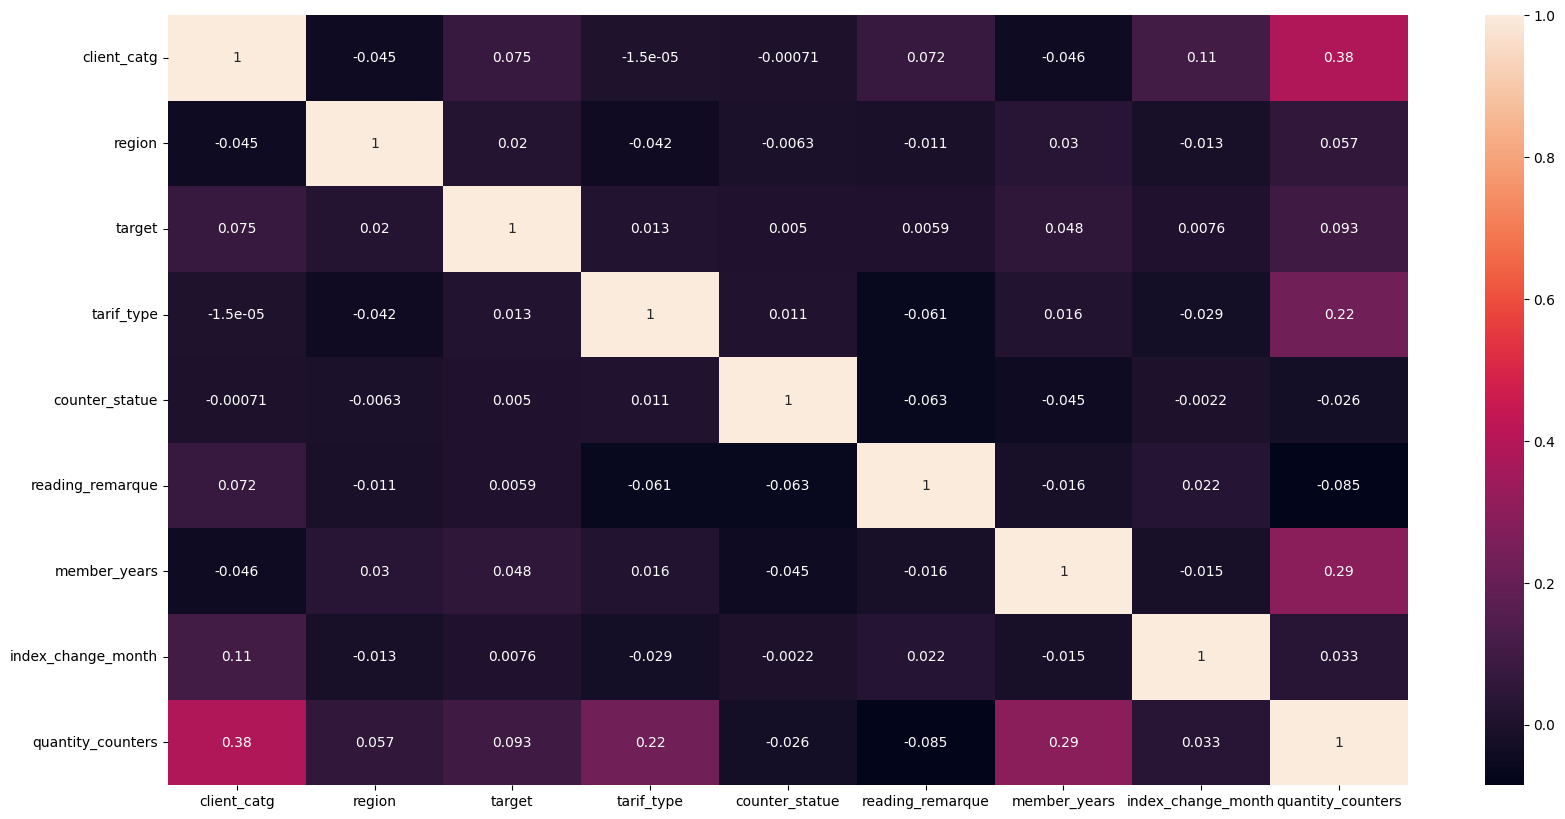

In [40]:
# heatmap
fig = plt.figure(figsize=(20,10))
sns.heatmap(df_processed[['client_catg', 'region', 'target', 'tarif_type', 'counter_statue',
       'reading_remarque',  'member_years',
       'index_change_month', 'quantity_counters']].corr(), annot=True)


## Turning Categorical Features into Dummies

In [41]:
df_processed.columns.to_list()

['client_catg',
 'region',
 'target',
 'tarif_type',
 'counter_statue',
 'reading_remarque',
 'counter_type',
 'member_years',
 'index_change_month',
 'quantity_counters']

In [42]:
cat_features = ['client_catg',
 'region',
 'tarif_type',
 'counter_statue',
 'reading_remarque',
 'counter_type']

In [43]:
num_features = [x for x in df_processed.columns.to_list() if x not in cat_features]
num_features

['target', 'member_years', 'index_change_month', 'quantity_counters']

In [44]:
# remove target
num_features.remove("target")
num_features

['member_years', 'index_change_month', 'quantity_counters']

In [45]:
#make dummy variables from categorical features, dtype int
dummies = pd.get_dummies(df_processed[cat_features], columns=cat_features, drop_first=True, dtype=int)
dummies

,client_catg_12,client_catg_51,region_103,region_104,region_105,region_106,region_107,region_199,region_206,region_301,...,tarif_type_45,counter_statue_1.0,counter_statue_2.0,counter_statue_3.0,counter_statue_4.0,counter_statue_5.0,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_GAZ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476685,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4476686,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4476687,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4476688,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#%store -z

In [46]:
# add dummy variables to dataframe with dropped categorical columns
df_processed_dmy =  pd.concat([df_processed.drop(cat_features,axis=1), dummies],axis=1)
df_processed_dmy.head()

,target,member_years,index_change_month,quantity_counters,client_catg_12,client_catg_51,region_103,region_104,region_105,region_106,...,tarif_type_45,counter_statue_1.0,counter_statue_2.0,counter_statue_3.0,counter_statue_4.0,counter_statue_5.0,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_GAZ
0,0,20,20.500000,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,19,346.000000,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,21,30.750000,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,21,25.500000,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,22,47.666667,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [47]:
df_processed_dmy.shape

(4476690, 48)

In [48]:
# store the preprocessed dataframe
df_processed_dmy.to_csv('data/df_processed_dmy.csv', index=False)

# # add to new notebooks:
# # load the preprocessed dataframe
# %store -r df_processed_dmy

In [ ]:
#%store -z

## Turning Categorical Features into Dummys for Tree-Models (no drop-first)

In [49]:
#make dummy variables from categorical features, dtype int, without dropping the first dummy columns
dummies_tree = pd.get_dummies(df_processed[cat_features], columns=cat_features, drop_first=False, dtype=int)
dummies_tree

,client_catg_11,client_catg_12,client_catg_51,region_101,region_103,region_104,region_105,region_106,region_107,region_199,...,counter_statue_2.0,counter_statue_3.0,counter_statue_4.0,counter_statue_5.0,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_ELEC,counter_type_GAZ
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476685,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4476686,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4476687,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4476688,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [50]:
# add dummy variables to dataframe with dropped categorical columns
df_processed_dmy_tree =  pd.concat([df_processed.drop(cat_features,axis=1), dummies_tree],axis=1)
df_processed_dmy_tree.head()

,target,member_years,index_change_month,quantity_counters,client_catg_11,client_catg_12,client_catg_51,region_101,region_103,region_104,...,counter_statue_2.0,counter_statue_3.0,counter_statue_4.0,counter_statue_5.0,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_ELEC,counter_type_GAZ
0,0,20,20.500000,35,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,19,346.000000,35,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,21,30.750000,35,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,21,25.500000,35,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,22,47.666667,35,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0


In [51]:
# store the preprocessed dataframe for tree models
df_processed_dmy_tree.to_csv('data/df_processed_dmy_tree.csv', index=False)

## To Dos

* counter_code: find info on steg site or drop?
* reading_remarque: clean? 
* counter_coefficient: try both?: treat numerically and as dummies?
* rescale consommation_level1 ... _4
* rescale months_number

## Done
* rename 'disrict' column 'district'
* turn creation_date, invoice_date  into datetime
* change target to 0,1
* counter_statue: turn strings 0-5 into int, check percentage of values not 0-5, check for pattern, remove
* feature engineering: index_change = new_idex - old_index. then drop new_index, old_index
* feature engineering: number of counters per client. then drop client_id, counter_number
* turn into dummies: cat_features = ['district', 'client_catg', 'region', 'tarif_type', 'counter_statue', 'counter_code', 'reading_remarque', 'counter_coefficient', 'counter_type']
* export processed dataframe
* turn date columns into months and year columns


In [ ]:
# save current version of processed data for use later

#df_processed.to_csv('data/fraud_data_processed_V1.csv', index=False)


In [52]:
#store num-features
%store num_features

Stored 'num_features' (list)
